<a href="https://colab.research.google.com/github/kylemath/DeepEEG/blob/master/notebooks/DeepEEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepEEG


In [1]:
!git clone https://github.com/kylemath/DeepEEG
!chmod +x ./DeepEEG/install.sh
!./DeepEEG/install.sh
%matplotlib inline


Cloning into 'DeepEEG'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 392 (delta 46), reused 44 (delta 20), pack-reused 316
Receiving objects: 100% (392/392), 15.43 MiB | 23.33 MiB/s, done.
Resolving deltas: 100% (176/176), done.
    100% |████████████████████████████████| 6.2MB 5.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/59/23/bb/ebafe2eae31064edfb9b384131abd0ec562a9418601cde6d69
Successfully built mne


#Connect to Google Drive

In [0]:
#mount google drive to load own images, follow link and get code and paste in below
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


#Run Brain Recorder Loading Data

*  Each data file is from a condition in an EEG experiment, from folder in google drive


In [0]:
from DeepEEG.utils import load_data
#Data Settings#
path = 'gdrive/My Drive/data/'
exp = 'bikepark'
conditions = ['quiet','traffic']
subs = ['005', '007', '009', '010', '012', '013', '014', '015', '016', '019']
subs = [ '015']

event_names = ['Standard','Target']
event_nums = [1,2] # 1 Standard, 2 Target, 9 Response

#exp = 'P2_Soundz'
#conditions = ['']
#subs = ['001', '003', '004', '005', '006', '007', '009', '010', '011', '012', '013', '015', '016', '017'];#P2_Sounds
#subs = ['006']
#event_names = ['Standard/Silent','Standard/Sound','Standard/White','Standard/Silent_Low',
#               'Target/Silent','Target/Sound','Target/White','Target/Silent_Low']
#event_nums = [1,8,5,7,2,3,6,9]


for isub,sub in enumerate(subs):       
  print('Loading data for subject number: ' + sub)
  
  
  for icond, condition in enumerate(conditions):
    
    if len(conditions) > 1:
      fname = path + exp + '/' + sub + '_' + exp + '_' + condition + '.vhdr'
    else:
      fname = path + exp + '/' + sub + '_' + exp + '.vhdr'
      
    tempraw,sfreq = load_data(fname,data_type='recorder',plot_sensors=False,plot_raw=False,plot_raw_psd=False,stim_channel=True)
    if icond==0 and isub==0:
      raw = tempraw
    else:
      raw.append(tempraw)

Using TensorFlow backend.


Loading data for subject number: 015
Extracting parameters from gdrive/My Drive/data/bikepark/015_bikepark_quiet.vhdr...
Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 1262439  =      0.000 ...  2524.878 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations
Extracting parameters from gdrive/My Drive/data/bikepark/015_bikepark_traffic.vhdr...
Setting channel info structure...


DeepEEG/utils.py:49: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  preload=True,stim_channel=stim_channel)


Reading 0 ... 940909  =      0.000 ...  1881.818 secs...
Used Annotations descriptions: ['Stimulus/S 11', 'Stimulus/S 15', 'Stimulus/S  7', 'Stimulus/S  6', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  1', 'Stimulus/S  9', 'Stimulus/S255']
Sampling Rate = 500.0
Loading Channel Locations


<ipython-input-3-6001cb03264c>:36: RuntimeWarning: Omitted 1211 annotation(s) that were outside data range.
  raw.append(tempraw)


#Load Muse Data from eeg-notebooks

In [2]:
from DeepEEG.utils import muse_load_data

print('Muse data load')
!git clone https://github.com/kylemath/eeg-notebooks/

#Parameters#
#subject folders in data folder
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

data_dir = 'visual/cueing'
event_names = ['LeftCue','RightCue']
nsesh = 2
load_verbose = True


#for testing
#subs = [ 205, 207, 208, 209]
subs = [2]
nsesh = 1
#number of sessions in each subject folder

## Can load other experiments like this - NN and CNN model works great
#subs = [ 1]
#nsesh = 1
#data_dir = 'visual/P300'
#event_names = ['Standard','Target']
##

## Can load other experiments like this - NN and CNN model works best here
subs = [ 4]
nsesh = 1
data_dir = 'visual/SSVEP'
event_names = ['f30Hz','f20Hz']

##

sfreq = 256.
event_nums = [1,2]

#Load Data
print('Loading Data')
isub = subs[0]
raw = muse_load_data(data_dir, sfreq=sfreq ,subject_nb=isub, session_nb=1,verbose=load_verbose)
if nsesh == 2:
  raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))

if len(subs)>1:
  for isub in subs[1:]:
    print(isub)
    raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=1,verbose=load_verbose))
    if nsesh == 2:
      raw.append(muse_load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))
  



  
  

Using TensorFlow backend.


Muse data load
Cloning into 'eeg-notebooks'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1792 (delta 7), reused 0 (delta 0), pack-reused 1776
Receiving objects: 100% (1792/1792), 110.45 MiB | 18.81 MiB/s, done.
Resolving deltas: 100% (785/785), done.
Checking out files: 100% (487/487), done.
Loading Data
Creating RawArray with float64 data, n_channels=5, n_times=15372
    Range : 0 ... 15371 =      0.000 ...    60.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=15372
    Range :

#Run Preprocessing

Filtering Data
168 events found
Event IDs: [1 2]
('sample drop %: ', 100)


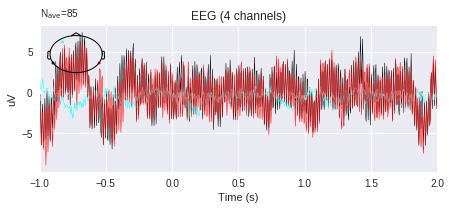

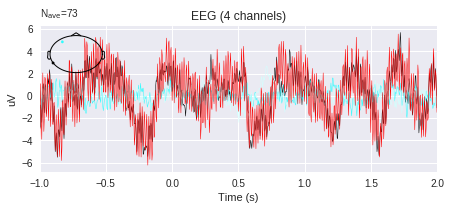

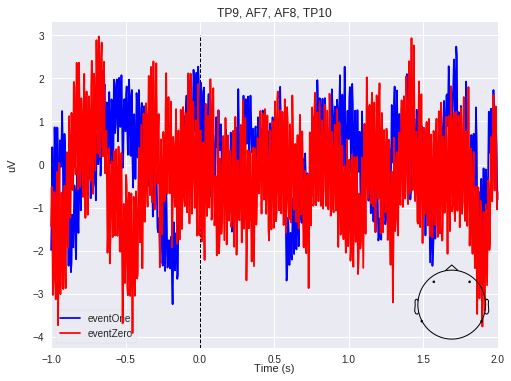

In [3]:
from DeepEEG.tools import preprocess
##Preprocessing Settings
event_id = {event_names[1]: event_nums[1], event_names[0]: event_nums[0]} #create dict

epochs = preprocess(raw, event_id, rej_thresh_uV=500,
                    plot_psd=False,plot_events=False,plot_erp=True)
                    

#plot_psd=False, filter_data=True, 
#eeg_filter_highpass=1, plot_events=False, epoch_time=(-.1,.8), 
#baseline=(-.1,0), rej_thresh_uV=150,
#epoch_decim=1, plot_electrodes=True,
#plot_erp=True

#keep epoch_decim=1 if using frequency_domain


#Run FeatureEngineer

In [4]:
from DeepEEG.tools import FeatureEngineer

#change this so epochs can either be a mne epochs object, 
#or can be an encoded latent space from the autoencoder
#automatically detects type
feats = FeatureEngineer( epochs, model_type = 'NN',
                             frequency_domain=1,wave_cycles=2,flims=(4,40),
                             electrodes_out=[0,1,2,3],spect_baseline=[-.1,0])

#frequency_domain=0, 
#normalization=True,
#electrode_median=False,                                                                                                                     
#wavelet_decim=1,flims=(2,30),
#f_bins=20,wave_cycles=3,
#spect_baseline=[-1,-.5],
#electrodes_out= [13,14,15],
##electrodes_out= pick_types(epochs.info, meg=False, eeg=True, eog=False),
#random_seed=1017

Constructing Frequency Domain Features
Computing Morlet Wavelets on f30Hz
Applying baseline correction (mode: mean)
Computing Morlet Wavelets on f20Hz
Applying baseline correction (mode: mean)
Condition one trials: 73
f20Hz Time Points: 512
f20Hz Frequencies: 20
Condition zero trials: 85
f30Hz Time Points: 512
f30Hz Frequencies: 20
Normalizing X
Combined X Shape: (158, 512, 80)
Combined Y Shape: (158,)
Y Example (should be 1s & 0s): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
X Range: -50.322453:101.04911
Input Shape: (512, 80)
('x_train shape:', (94, 512, 80))
(94, 'train samples')
(32, 'test samples')
(32, 'validation samples')
Class Weights: [0.95918367 1.04444444]


# Run CreateModel

In [6]:
from DeepEEG.tools import CreateModel
model, encoder = CreateModel(feats, 
                    model_type='NN', batch_size = 2)


Creating NN Model


# TrainTestVal

Training Model:
Train on 94 samples, validate on 32 samples
Epoch 1/20
94/94 [==============================] - 3s 32ms/step - loss: 1.3646 - acc: 0.5745 - val_loss: 0.9131 - val_acc: 0.5938
Epoch 2/20
94/94 [==============================] - 1s 7ms/step - loss: 0.9228 - acc: 0.5213 - val_loss: 1.0803 - val_acc: 0.5938
Epoch 3/20
94/94 [==============================] - 1s 7ms/step - loss: 0.8106 - acc: 0.5426 - val_loss: 0.9036 - val_acc: 0.5625
Epoch 4/20
94/94 [==============================] - 1s 6ms/step - loss: 0.6776 - acc: 0.5851 - val_loss: 0.7059 - val_acc: 0.5312
Epoch 5/20
94/94 [==============================] - 1s 6ms/step - loss: 0.7883 - acc: 0.5532 - val_loss: 0.7101 - val_acc: 0.5625
Epoch 6/20
94/94 [==============================] - 1s 6ms/step - loss: 0.5839 - acc: 0.6702 - val_loss: 0.6739 - val_acc: 0.5938
Epoch 7/20
94/94 [==============================] - 1s 6ms/step - loss: 0.6592 - acc: 0.6489 - val_loss: 0.7166 - val_acc: 0.5625
Epoch 8/20
94/94 [===========

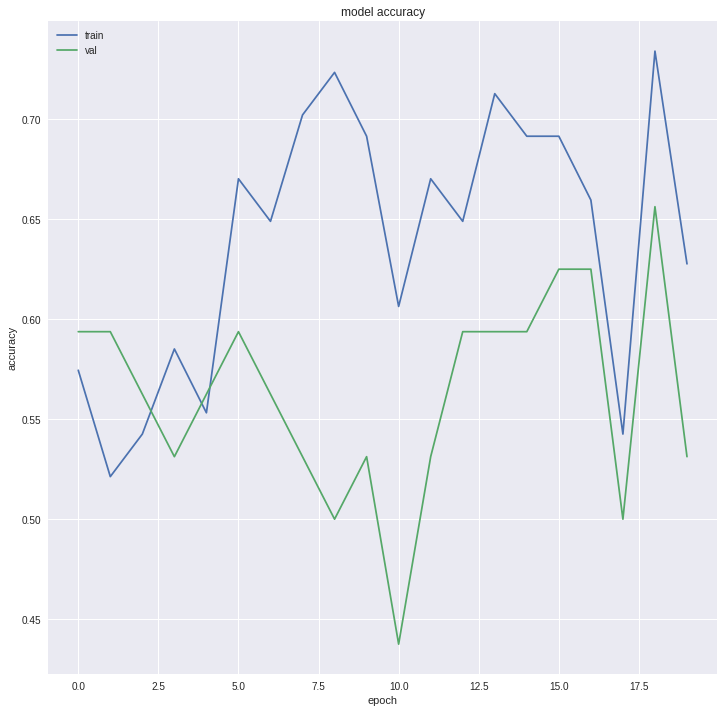

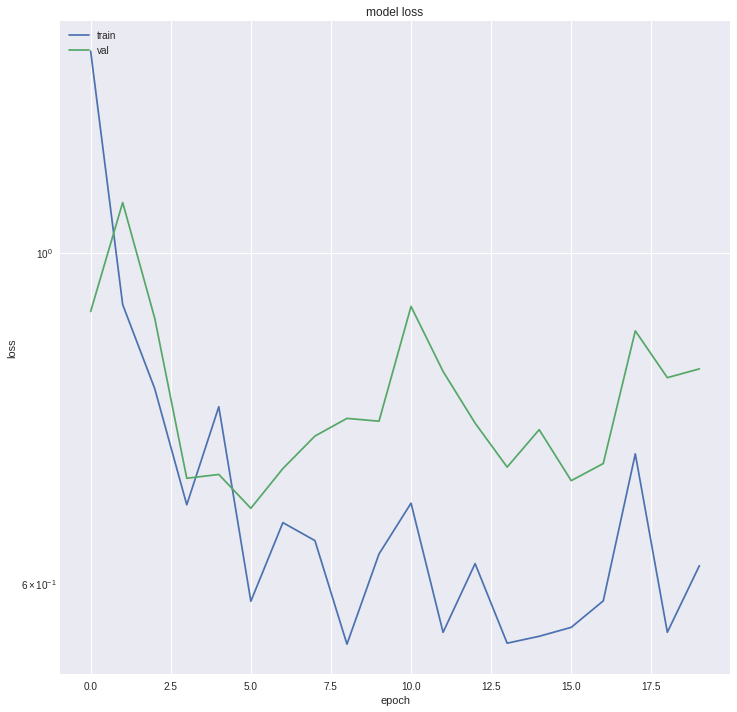

32/32 [==============================] - 0s 2ms/step
['loss', 'acc']
('Test loss:', 0.8365260418504477)
('Test accuracy:', 0.5625)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5243008   
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total param

In [8]:
from DeepEEG.tools import traintestval
traintestval(model, feats,
             batch_size=2,train_epochs=20,
             model_type='NN')

#Check the results of the autoencoder

x_all size: (753, 1024)
y_all size: (753, 2)
encoded_data size: (753, 16)
decoded_data size: (753, 1024)
x_all size: (753, 256, 4)
x_all size: (753, 1024)
(753, 256, 4)


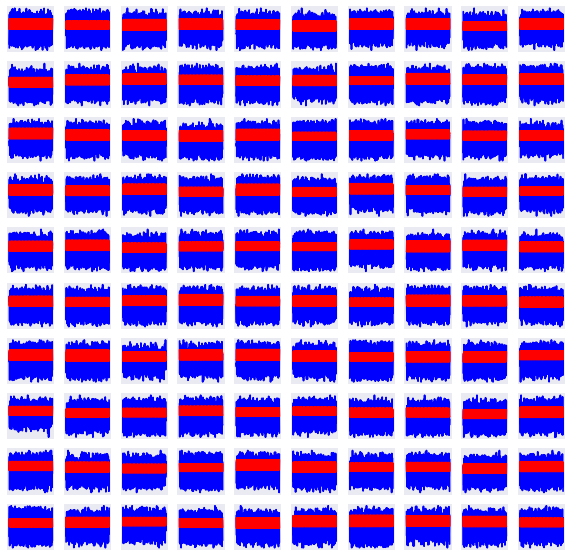

x_all Shape: (753, 256, 4)
y_all Shape: (753, 2)


ValueError: ignored

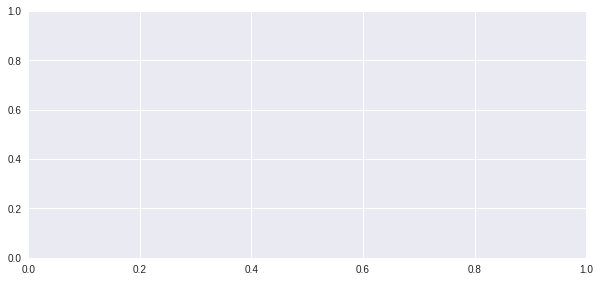

In [0]:
import numpy as np
from mne import pick_types
import matplotlib.pyplot as plt

x_all = np.append(x_train,np.append(x_val,x_test,axis=0),axis=0)
y_all = np.append(y_train,np.append(y_val,y_test,axis=0),axis=0)

#encoder input shape and decoder output shape are wrong for the data in the AUTODeep
encoded_data = encoder.predict(x_all)
decoded_data = model.predict(x_all)

print('x_all size: ' + str(x_all.shape))
print('y_all size: ' + str(y_all.shape))

print('encoded_data size: ' + str(encoded_data.shape))
print('decoded_data size: ' + str(decoded_data.shape))
#x_all size: (1587, 640)
#encoded_data size: (1587, 16)
#decoded_data size: (1587, 640)
#(1587, 40, 16)

nchans = len(pick_types(epochs.info, meg=False, eeg=True, eog=False))
ntimes = x_all.shape[1]/nchans
x_all = np.reshape(x_all,(x_all.shape[0],ntimes,nchans))
print('x_all size: ' + str(x_all.shape))
print('x_all size: ' + str(decoded_data.shape))

decoded_data = np.reshape(decoded_data,(decoded_data.shape[0],ntimes,nchans))
print(x_all.shape)

n = 10
chan = 0
#epochs.ch_names.index('Pz')
plt.figure(figsize=(10,10))
for i in range(n):
  for j in range(n):
    item_idx = (j*n)+i+1
    ax = plt.subplot(n,n,item_idx)
    plt.plot(x_all[item_idx,:,chan],'b')
    plt.plot(decoded_data[item_idx,:,chan],'r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()




print('x_all Shape: ' + str(x_all.shape))
print('y_all Shape: ' + str(y_all.shape))
chan = 0
#epochs.ch_names.index('Fz')

#divide into conditions
cond_zero_real = x_all[y_all[:,0]==0,:,chan]
cond_one_real = x_all[y_all[:,0]==1,:,chan]
cond_zero_decode = decoded_data[y_all[:,0]==0,:,chan]
cond_one_decode = decoded_data[y_all[:,0]==1,:,chan]

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
zero_err = np.std(cond_zero_real, axis=0)/10
one_err = np.std(cond_one_real, axis=0)/10
ax.fill_between(new_times, np.mean(cond_zero_real, axis=0)-zero_err, np.mean(cond_zero_real, axis=0)+zero_err,color=[.8,.8,1])
ax.plot(new_times,np.mean(cond_zero_real, axis=0),'b',label=event_names[0])
ax.fill_between(new_times, np.mean(cond_one_real, axis=0)-one_err, np.mean(cond_one_real, axis=0)+one_err,color=[1,.8,.8])
ax.plot(new_times,np.mean(cond_one_real, axis=0),'r',label=event_names[1])
plt.title('Real')
ax.legend()

ax = plt.subplot(2,1,2)
zero_err = np.std(cond_zero_decode, axis=0)/10
one_err = np.std(cond_one_decode, axis=0)/10
ax.fill_between(new_times, np.mean(cond_zero_decode, axis=0)-zero_err, np.mean(cond_zero_decode, axis=0)+zero_err,color=[.8,.8,1])
ax.plot(new_times,np.mean(cond_zero_decode, axis=0),'b',label=event_names[0])
ax.fill_between(new_times, np.mean(cond_one_decode, axis=0)-one_err, np.mean(cond_one_decode, axis=0)+one_err,color=[1,.8,.8])
ax.plot(new_times,np.mean(cond_one_decode, axis=0),'r',label=event_names[1])
plt.title('Autogenerated')
ax.legend()
plt.show()


#run the autoencoder embedded trials through a NN

Maybe the latent space could represent different components? 
frequency bands? 


Normalizing X


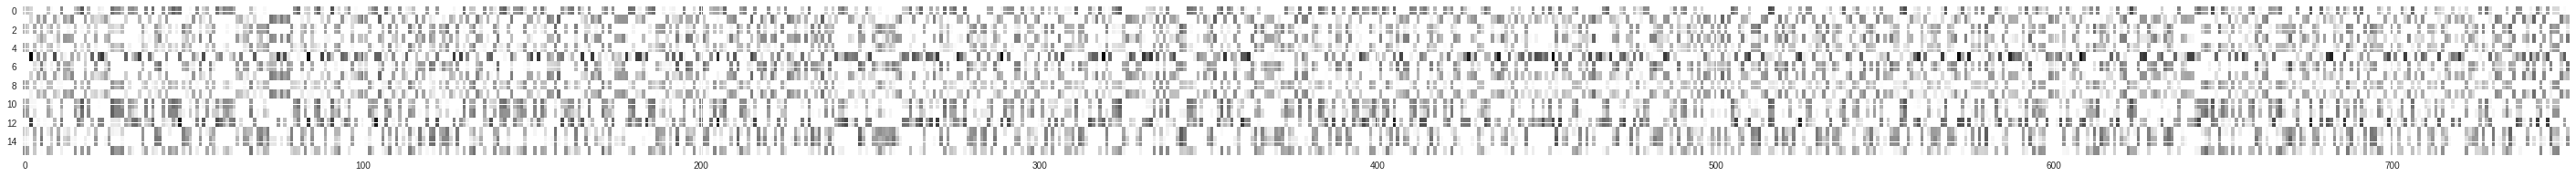

Combined X Shape: (753, 16, 1)
Combined Y Shape: (753, 2)
Y Example (should be 1s & 0s): [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
X Range: -0.8040612:3.650266
Input Shape: (16, 1)
('x_train shape:', (451, 16, 1))
(451, 'train samples')
(151, 'test samples')
(151, 'validation samples')
Class Weights: [0.59814324 3.0472973 ]


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


X= encoded_data 

print('Normalizing X')
X = (X - np.mean(X)) / np.std(X)

fig = plt.figure(figsize=(50,3))
plt.imshow(np.transpose(X),aspect='auto')
Y = y_all
plt.show()
X = np.expand_dims(X,2)

# Split training test and validation data 
test_split = 0.2
val_split = 0.2
random_seed=1017
val_prop = val_split / (1-test_split)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_prop, random_state=random_seed)

# Compute model input shape
input_shape = X.shape[1:]

#compute class weights for uneven classes
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced',
                                               np.unique(y_ints),
                                               y_ints)
#Print some outputs
print('Combined X Shape: ' + str(X.shape))
print('Combined Y Shape: ' + str(Y.shape))
print('Y Example (should be 1s & 0s): ' + str(Y[0:10]))
print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
print('Input Shape: ' + str(input_shape))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')
print('Class Weights: ' + str(class_weights))



Creating NN Model
Training Model:
Train on 451 samples, validate on 151 samples
Epoch 1/10
451/451 [==============================] - 1s 3ms/step - loss: 0.5549 - acc: 0.7627 - val_loss: 0.4337 - val_acc: 0.8477
Epoch 2/10
451/451 [==============================] - 1s 2ms/step - loss: 0.5299 - acc: 0.8137 - val_loss: 0.4359 - val_acc: 0.8477
Epoch 3/10
451/451 [==============================] - 1s 2ms/step - loss: 0.4734 - acc: 0.8160 - val_loss: 0.4418 - val_acc: 0.8477
Epoch 4/10
451/451 [==============================] - 1s 2ms/step - loss: 0.4875 - acc: 0.8293 - val_loss: 0.4345 - val_acc: 0.8477
Epoch 5/10
451/451 [==============================] - 1s 2ms/step - loss: 0.5119 - acc: 0.8248 - val_loss: 0.4319 - val_acc: 0.8477
Epoch 6/10
451/451 [==============================] - 1s 2ms/step - loss: 0.4912 - acc: 0.8248 - val_loss: 0.4317 - val_acc: 0.8477
Epoch 7/10
451/451 [==============================] - 1s 2ms/step - loss: 0.4738 - acc: 0.8204 - val_loss: 0.4372 - val_acc: 0.8

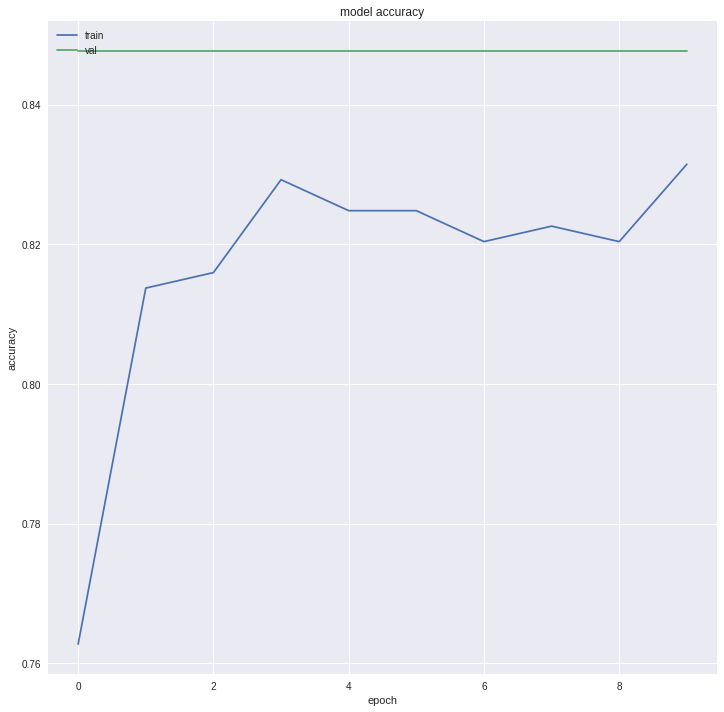

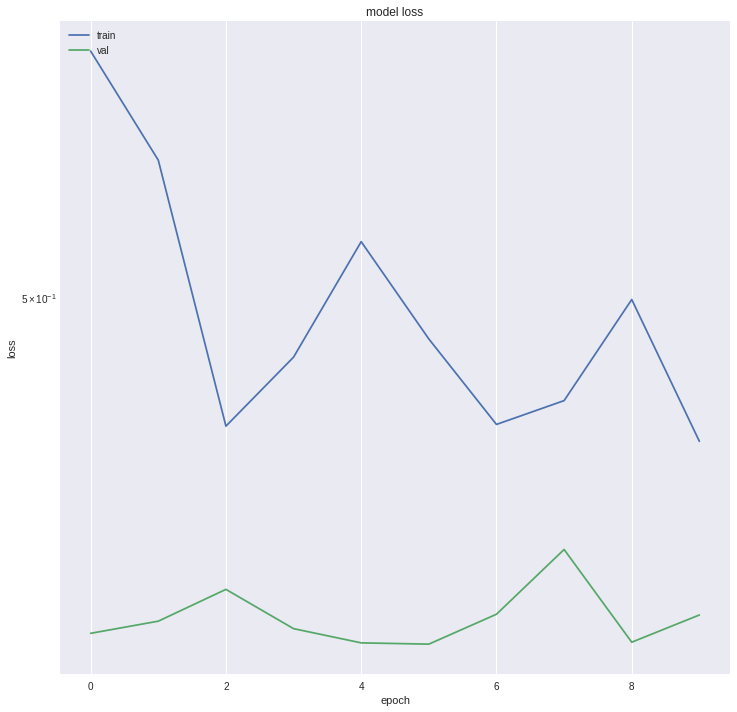

151/151 [==============================] - 0s 612us/step
['loss', 'acc']
('Test loss:', 0.4799940226883288)
('Test accuracy:', 0.8344370860927153)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2176      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258   

In [0]:
model, encoder = CreateModel(input_shape,num_classes, 
                    model_type='NN', batch_size = 4)

traintestval(model, class_weights,
             x_train,x_test,x_val,
             y_train,y_test,y_val,
             batch_size=4,train_epochs=10,
             model_type='NN')